In [188]:
# NOTE: import library

from google.colab import drive

from os import listdir
from os.path import join
import os.path

from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchsummary import summary

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import random

In [189]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using {device}')

using cuda


In [190]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [191]:
sourcePath = "/content/" # path to dataset

if not os.path.isdir(sourcePath + 'extracted_images'):
  !unrar x "/content/drive/MyDrive/math_data.rar" # path to dataset
else:
  print('already exist')

already exist


In [192]:
print("")
label = {}
num = 0
for className in listdir(join(sourcePath, "extracted_images")) :
  print(f"{className}:{len(listdir(join(sourcePath, 'extracted_images', className)))}")
  label[className] = num
  num += 1


w:556
lambda:109
l:1017
log:2001
leq:973
6:3118
5:3545
infty:1783
ldots:609
-:33997
+:25112
lim:1675
M:2476
gamma:409
e:3003
0:6914
cos:2986
times:3251
int:2742
v:1558
tan:2450
p:2680
T:3274
G:1692
in:47
rightarrow:1703
ascii_124:1339
=:13104
sin:4293
o:449
exists:21
,:1906
4:7396
7:2909
y:9340
]:780
geq:693
beta:2025
3:10909
9:3737
2:26141
):14355
forall:45
b:8651
H:1464
phi:355
k:3074
{:376
q:1230
S:1413
prime:329
C:5802
d:4852
8:3068
R:2671
sqrt:8908
f:3712
pm:802
(:14294
Delta:137
}:377
alpha:2546
u:1269
z:5870
mu:177
sigma:201
i:5140
sum:2689
neq:558
N:10862
forward_slash:199
1:26520
j:1536
div:868
X:26594
lt:477
gt:258
A:12367
pi:2332
!:1300
[:778
theta:2796


In [193]:
# class MathDataSet(Dataset):
#   def __init__(self):
#     pass

#   def __len__(self):
#     pass
  
#   def __getitem__(self):
#     pass



class myDataLoader(Dataset) :
  def __init__(self, opt, forMetric) :
    super(myDataLoader, self).__init__()

    self.opt = opt
    self.forMetric = forMetric
    self.imageDataset = self.getPathList()
    self.label = label
    
  def __getitem__(self, index) :
    image = Image.open(self.imageDataset[0][index]).convert("RGB") #4D to 3D
    image = self.transforms(image)

    label = self.label[self.imageDataset[1][index]]
    
    return {"image":image, "label":torch.as_tensor(label).float()}
    
  def __len__(self) :
    return len(self.imageDataset[1])

  def getPathList(self) :
    if self.forMetric :
      classPath = join(self.opt["dataRoot"], "test")
    else :
      classPath = join(self.opt["dataRoot"], "train")

    imagePathList, imageLabelList = [], []
    for className in listdir(classPath) :
      for imageName in listdir(join(classPath, className)) :
        imagePathList.append(join(classPath, className, imageName))
        imageLabelList.append(className)
    
    return (imagePathList, imageLabelList)
  
  def transforms(self, image) :
    if self.forMetric :
      myTransforms = transforms.Compose([transforms.Resize(self.opt["cropSize"]),
                                        transforms.ToTensor()]) # Resize Process for Test
    else :
      myTransforms = transforms.Compose([transforms.RandomCrop(self.opt["cropSize"]),
                                        transforms.ToTensor()]) # Random Crop for Training
    image = myTransforms(image)

    return image

In [194]:
trans = transforms.Compose([transforms.Resize((100,100)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                            ])
trainset = torchvision.datasets.ImageFolder(root = sourcePath + 'extracted_images',
                                            transform = trans)

len(trainset.classes)

82

In [195]:
classes = trainset.classes

In [196]:
train_size = int(0.8 * len(trainset))
test_size = len(trainset) - train_size

train_data, test_data = torch.utils.data.random_split(trainset, [train_size, test_size])

train_loader = DataLoader(train_data,
                         batch_size = 16,
                         shuffle = True)

test_loader = DataLoader(test_data,
                         batch_size = 16,
                         shuffle = False)

print(f'train size = {train_size}\ntest size = {test_size}')
print('')
print(f'training data set = {len(train_loader)}\ntest data set = {len(test_loader)}')

train size = 300779
test size = 75195

training data set = 18799
test data set = 4700


In [197]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.size())
print(labels.size())

torch.Size([16, 3, 100, 100])
torch.Size([16])


In [198]:
def imshow(img):
  img = img / 2 + 0.5
  np_img = img.numpy()
  plt.imshow(np.transpose(np_img, (1,2,0)))
  print(np_img.shape)
  print((np.transpose(np_img, (1,2,0))).shape)


torch.Size([16, 3, 100, 100])
(3, 410, 410)
(410, 410, 3)
torch.Size([16, 3, 100, 100])
torch.Size([3, 206, 818])
    X     +     =     =    lt     X     R     A     v  sqrt     (     9 alpha     -     9     7 


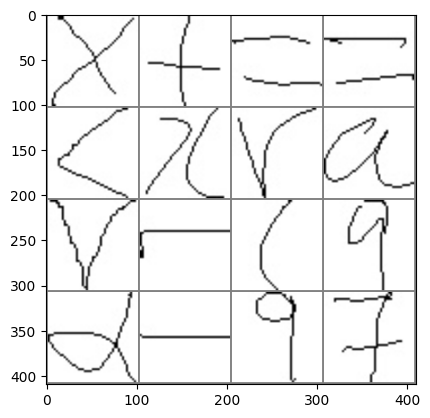

In [199]:
print(images.shape)
imshow(torchvision.utils.make_grid(images, nrow = 4))
print(images.shape)
print((torchvision.utils.make_grid(images)).shape)
print(''.join('%5s '%classes[labels[j]] for j in range(16)))

In [200]:
class myModel(nn.Module) :
  def __init__(self, opt) :
    super(myModel, self).__init__()

    inputDim, targetDim, channels = 3, len(label), 64

    self.layer0 = nn.Sequential(nn.Conv2d(inputDim, channels, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer1 = nn.Sequential(nn.Conv2d(channels, channels*2, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer2 = nn.Sequential(nn.Conv2d(channels*2, channels*4, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer3 = nn.Sequential(nn.Conv2d(channels*4, channels*4, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer4 = nn.Linear(channels*4, targetDim)

  def forward(self, input) :
    output = self.layer0(input)
    output = self.layer1(output)
    output = self.layer2(output)
    output = self.layer3(output)
    output = F.adaptive_avg_pool2d(output, (1,1)).view(output.size(0), -1)
    output = self.layer4(output)

    return output
     

In [201]:
def fixSeed(seed) :
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [202]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val*n
        self.count += n
        self.avg = self.sum / self.count

In [203]:
def computeAcc(pred, target) :
  acc = (torch.argmax(pred)==torch.argmax(target)).sum()/pred.size(0)

  return acc

In [204]:
opt = {"dataRoot":"/content/",
       "cropSize":100,
       "seed":42,
       "inputDim":3,
       "targetDim":len(trainset.classes),
       "channels":64,
       "batchSize":16, 
       "lr":1e-4, 
       "epochs":10, 
       "isCUDA":torch.cuda.is_available()}

In [205]:
def train(opt, myDataLoader, myModel, criterion) :
  fixSeed(opt["seed"])

  trainDataLoader = train_loader
  testDataLoader = test_loader

  fixSeed(opt["seed"])
  model = myModel(opt)
  if opt["isCUDA"] :
    model = model.cuda()

  summary(model, (opt["inputDim"], opt["cropSize"], opt["cropSize"]))

  optimizer = optim.Adam(model.parameters(), lr=opt["lr"])
  
  trainLoss, testLoss = AverageMeter(), AverageMeter()
  trainAcc, testAcc = AverageMeter(), AverageMeter()
  trainLossList, testLossList = [], []
  trainAccList, testAccList = [], []
  bestAcc = 0

  for epoch in range(1, opt['epochs']+1) :
    trainBar = tqdm(trainDataLoader)
    trainLoss.reset(), trainAcc.reset()

    for input, target in trainBar :
      # input, target = image, label
      if opt["isCUDA"] :
        input, target = input.cuda(), target.cuda()

      optimizer.zero_grad()
      pred = model(input)
      loss = criterion(pred, target)
      loss.backward()
      optimizer.step()

      trainLoss.update(loss.item(), opt["batchSize"])
      trainAcc.update(computeAcc(pred, target).item(), opt["batchSize"])
      trainBar.set_description(desc=f"[{epoch}/{opt['epochs']}] [Train] < Accuracy:{trainAcc.avg:.6f} | Loss:{trainLoss.avg:.6f} >")

    trainLossList.append(trainLoss.avg)
    trainAccList.append(trainAcc.avg)

    testBar = tqdm(testDataLoader)
    testLoss.reset(), testAcc.reset()

    for input, target in testBar :
      # input, target = data["image"], data["label"]
      if opt["isCUDA"] :
        input, target = input.cuda(), target.cuda()

      model.eval()
      with torch.no_grad() :
        pred = model(input)
        loss = criterion(pred, target)

        testLoss.update(loss.item(), opt["batchSize"])
        testAcc.update(computeAcc(pred, target).item(), opt["batchSize"])
        testBar.set_description(desc=f"[{epoch}/{opt['epochs']}] [Test] < Accuracy:{testAcc.avg:.6f} | Loss:{testLoss.avg:.6f} >")

    testLossList.append(testLoss.avg)
    testAccList.append(testAcc.avg)

    if testAcc.avg > bestAcc :
      bestAcc = testAcc.avg
      torch.save(model.state_dict(), "bestModel.pth")

    torch.save(model.state_dict(), "latestModel.pth")

  return model, (trainLossList, testLossList), (trainAccList, testAccList)

In [ ]:
model, lossList, accList = train(opt, myDataLoader, myModel, nn.CrossEntropyLoss())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]           1,792
              ReLU-2         [-1, 64, 100, 100]               0
         MaxPool2d-3           [-1, 64, 50, 50]               0
            Conv2d-4          [-1, 128, 50, 50]          73,856
              ReLU-5          [-1, 128, 50, 50]               0
         MaxPool2d-6          [-1, 128, 25, 25]               0
            Conv2d-7          [-1, 256, 25, 25]         295,168
              ReLU-8          [-1, 256, 25, 25]               0
         MaxPool2d-9          [-1, 256, 12, 12]               0
           Conv2d-10          [-1, 256, 12, 12]         590,080
             ReLU-11          [-1, 256, 12, 12]               0
        MaxPool2d-12            [-1, 256, 6, 6]               0
           Linear-13                   [-1, 82]          21,074
Total params: 981,970
Trainable params:

[1/10] [Train] < Accuracy:0.000219 | Loss:0.774406 >: 100%|██████████| 18799/18799 [10:02<00:00, 31.19it/s]
[1/10] [Test] < Accuracy:0.000133 | Loss:0.377851 >: 100%|██████████| 4700/4700 [01:57<00:00, 40.10it/s]
[2/10] [Train] < Accuracy:0.000156 | Loss:0.288255 >: 100%|██████████| 18799/18799 [10:02<00:00, 31.21it/s]
[2/10] [Test] < Accuracy:0.000106 | Loss:0.238496 >: 100%|██████████| 4700/4700 [01:56<00:00, 40.31it/s]
[3/10] [Train] < Accuracy:0.000110 | Loss:0.209790 >: 100%|██████████| 18799/18799 [10:02<00:00, 31.22it/s]
[3/10] [Test] < Accuracy:0.000120 | Loss:0.198815 >: 100%|██████████| 4700/4700 [01:55<00:00, 40.53it/s]
[4/10] [Train] < Accuracy:0.000083 | Loss:0.167867 >: 100%|██████████| 18799/18799 [09:57<00:00, 31.44it/s]
[4/10] [Test] < Accuracy:0.000080 | Loss:0.176983 >: 100%|██████████| 4700/4700 [01:56<00:00, 40.23it/s]
[5/10] [Train] < Accuracy:0.000113 | Loss:0.139136 >: 100%|██████████| 18799/18799 [09:59<00:00, 31.38it/s]
[5/10] [Test] < Accuracy:0.000053 | Loss

In [ ]:
torch.save(model, f'./math_model.pt')